In [ ]:
import pandas as pd
import numpy as np

# Simulate power data
np.random.seed(42)
timestamps = pd.date_range(start="2021-01-01", periods=10000, freq="10min")
power = np.abs(np.sin(np.linspace(0, 50, 10000)) + np.random.normal(0, 0.2, 10000)) * 1000

df = pd.DataFrame({
    "Date/Time": timestamps,
    "LV ActivePower (kW)": power
})
df.to_csv("T1.csv", index=False)
print("✅ T1.csv has been created.")


✅ T1.csv has been created.


Epoch 1/10, Loss: 519548.3125
Epoch 2/10, Loss: 515196.0938
Epoch 3/10, Loss: 513901.0312
Epoch 4/10, Loss: 513590.0625
Epoch 5/10, Loss: 513496.9062
Epoch 6/10, Loss: 513432.0312
Epoch 7/10, Loss: 513360.6875
Epoch 8/10, Loss: 513275.9688
Epoch 9/10, Loss: 513183.8438
Epoch 10/10, Loss: 513094.0625

📊 AUC Score: 0.1093
🚨 False Positive Rate: 0.0135
⏱️ Training Time: 151.88 seconds


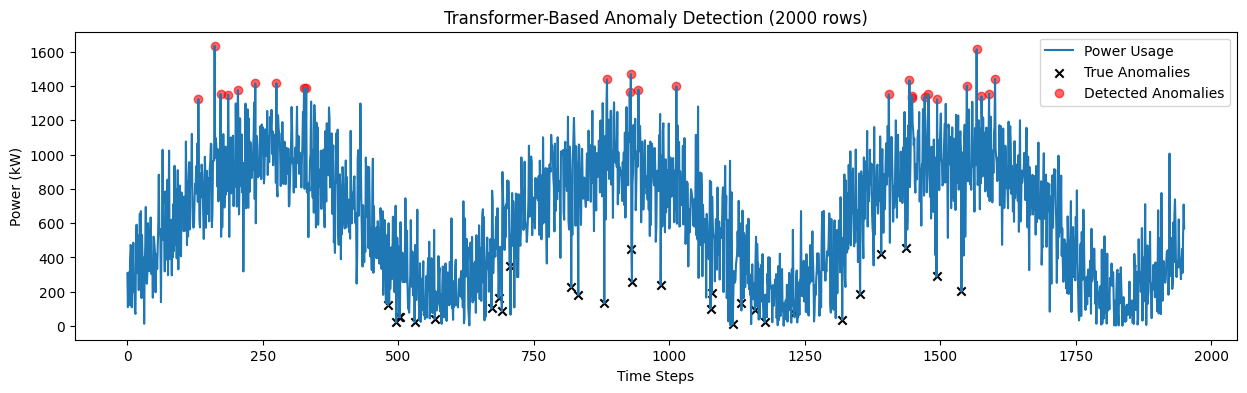

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix

# 1. Load & preprocess dataset (reduced to 2000 rows)
df = pd.read_csv("T1.csv", parse_dates=["Date/Time"], nrows=2000)
df = df.sort_values("Date/Time")[["Date/Time", "LV ActivePower (kW)"]]
df.rename(columns={"LV ActivePower (kW)": "power"}, inplace=True)
df["power"] = df["power"].ffill()

# 2. Inject synthetic anomalies (same as before)
np.random.seed(42)
anomaly_indices = np.random.choice(df.index[500:1900], size=30, replace=False)
df["anomaly"] = 0
df.loc[anomaly_indices, "power"] *= np.random.uniform(0.1, 0.5, size=30)
df.loc[anomaly_indices, "anomaly"] = 1

# 3. Create sliding windows
def create_windows(data, window_size=48):
    X, y, labels = [], [], []
    for i in range(len(data) - window_size - 1):
        window = data["power"].values[i:i + window_size]
        target = data["power"].values[i + window_size]
        label = int(data["anomaly"].values[i + window_size])
        X.append(window)
        y.append(target)
        labels.append(label)
    return np.array(X), np.array(y), np.array(labels)

window_size = 48
X, y, true_labels = create_windows(df, window_size)
X_tensor = torch.tensor(X).unsqueeze(-1).float()
y_tensor = torch.tensor(y).float()

# 4. Transformer model
class TransformerAnomalyDetector(nn.Module):
    def __init__(self, seq_len, d_model=32, nhead=2, num_layers=&):
        super().__init__()
        self.input_proj = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.transformer(x)
        return self.output_proj(x)

model = TransformerAnomalyDetector(seq_len=window_size)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# 5. Training (10 epochs)
start_time = time.time()
epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    pred = model(X_tensor)[:, -1].squeeze()
    loss = criterion(pred, y_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
train_time = time.time() - start_time

# 6. Anomaly detection
model.eval()
with torch.no_grad():
    preds = model(X_tensor)[:, -1].squeeze()
    errors = torch.abs(preds - y_tensor)

# 7. Threshold-based binary classification
threshold = errors.mean() + 2 * errors.std()
pred_labels = (errors > threshold).int().numpy()

# 8. Evaluation metrics
auc = roc_auc_score(true_labels, errors.numpy())
tn, fp, fn, tp = confusion_matrix(true_labels, pred_labels).ravel()
fpr = fp / (fp + tn + 1e-6)

print(f"\n📊 AUC Score: {auc:.4f}")
print(f"🚨 False Positive Rate: {fpr:.4f}")
print(f"⏱️ Training Time: {train_time:.2f} seconds")

# 9. Visualization
plt.figure(figsize=(15, 4))
plt.plot(y_tensor.numpy(), label="Power Usage")
plt.scatter(np.where(true_labels == 1), y_tensor.numpy()[true_labels == 1], color='black', marker='x', label="True Anomalies")
plt.scatter(np.where(pred_labels == 1), y_tensor.numpy()[pred_labels == 1], color='red', alpha=0.6, label="Detected Anomalies")
plt.legend()
plt.title("Transformer-Based Anomaly Detection (2000 rows)")
plt.xlabel("Time Steps")
plt.ylabel("Power (kW)")
plt.show()


Epoch 1/10, Loss: 0.1486
Epoch 2/10, Loss: 2.7248
Epoch 3/10, Loss: 0.9025
Epoch 4/10, Loss: 0.1043
Epoch 5/10, Loss: 0.2121
Epoch 6/10, Loss: 0.3583
Epoch 7/10, Loss: 0.3117
Epoch 8/10, Loss: 0.1958
Epoch 9/10, Loss: 0.1057
Epoch 10/10, Loss: 0.0789

📊 AUC Score: 0.8150
🚨 False Positive Rate: 0.0094
⏱️ Training Time: 60.74 seconds


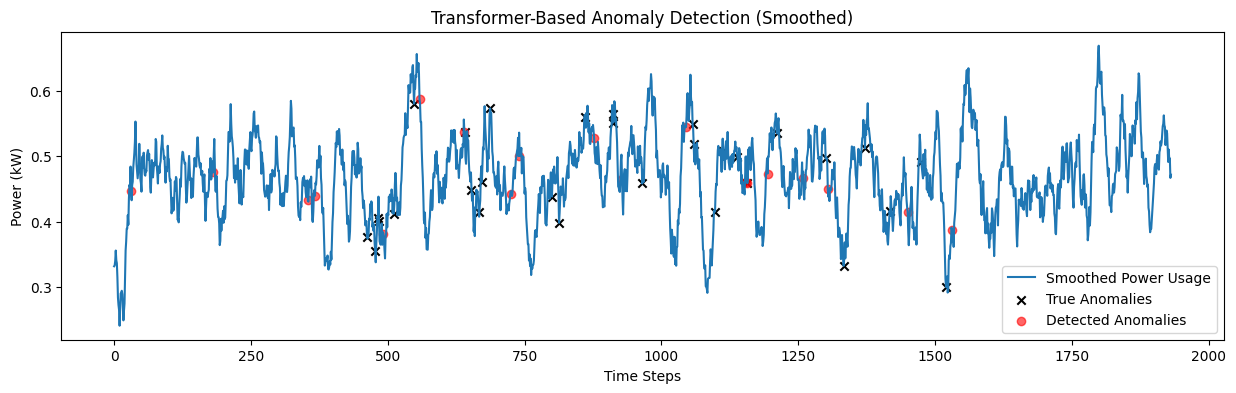

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix

# 1. Load & preprocess dataset (reduced to 2000 rows)
df = pd.read_csv("smart_grid_tx_normalized_encoder_hash1.csv", nrows=2000)
df = df.sort_values("block_index")[["block_index", "Power_Consumption(kW)"]]
df.rename(columns={"Power_Consumption(kW)": "power"}, inplace=True)
df["power"] = df["power"].ffill()

# 2. Inject synthetic anomalies (same as before)
np.random.seed(42)
anomaly_indices = np.random.choice(df.index[500:1900], size=30, replace=False)
df["anomaly"] = 0
df.loc[anomaly_indices, "power"] *= np.random.uniform(0.1, 0.5, size=30)
df.loc[anomaly_indices, "anomaly"] = 1

# 3. Create sliding windows
def create_windows(data, window_size=48):
    X, y, labels = [], [], []
    for i in range(len(data) - window_size - 1):
        window = data["power"].values[i:i + window_size]
        target = data["power"].values[i + window_size]
        label = int(data["anomaly"].values[i + window_size])
        X.append(window)
        y.append(target)
        labels.append(label)
    return np.array(X), np.array(y), np.array(labels)

window_size = 48
X, y, true_labels = create_windows(df, window_size)
X_tensor = torch.tensor(X).unsqueeze(-1).float()
y_tensor = torch.tensor(y).float()

# 4. Transformer model
class TransformerAnomalyDetector(nn.Module):
    def __init__(self, seq_len, d_model=32, nhead=2, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.transformer(x)
        return self.output_proj(x)

model = TransformerAnomalyDetector(seq_len=window_size)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# 5. Training (10 epochs)
start_time = time.time()
epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    pred = model(X_tensor)[:, -1].squeeze()
    loss = criterion(pred, y_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
train_time = time.time() - start_time

# 6. Anomaly detection
model.eval()
with torch.no_grad():
    preds = model(X_tensor)[:, -1].squeeze()
    errors = torch.abs(preds - y_tensor)

# 7. Threshold-based binary classification
threshold = errors.mean() + 2 * errors.std()
pred_labels = (errors > threshold).int().numpy()

# 8. Evaluation metrics
auc = roc_auc_score(true_labels, errors.numpy())
tn, fp, fn, tp = confusion_matrix(true_labels, pred_labels).ravel()
fpr = fp / (fp + tn + 1e-6)

print(f"\n📊 AUC Score: {auc:.4f}")
print(f"🚨 False Positive Rate: {fpr:.4f}")
print(f"⏱️ Training Time: {train_time:.2f} seconds")

# 9. Visualization
window = 20
smoothed = np.convolve(y_tensor.numpy(), np.ones(window)/window, mode='valid')
plt.figure(figsize=(15, 4))
plt.plot(smoothed, label="Smoothed Power Usage")
plt.scatter(np.where(true_labels[window-1:] == 1), smoothed[true_labels[window-1:] == 1], color='black', marker='x', label="True Anomalies")
plt.scatter(np.where(pred_labels[window-1:] == 1), smoothed[pred_labels[window-1:] == 1], color='red', alpha=0.6, label="Detected Anomalies")
plt.legend()
plt.title("Transformer-Based Anomaly Detection (Smoothed)")
plt.xlabel("Time Steps")
plt.ylabel("Power (kW)")
plt.show()




In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix

# 1. Load & preprocess dataset (reduced to 2000 rows)
df = pd.read_csv("smart_grid_tx_normalized_encoder_hash1.csv", nrows=2000)
df = df.sort_values("block_index")[["block_index", "Power_Consumption(kW)"]]
df.rename(columns={"Power_Consumption(kW)": "power"}, inplace=True)
df["power"] = df["power"].ffill()

# 2. Inject synthetic anomalies (same as before)
np.random.seed(42)
anomaly_indices = np.random.choice(df.index[500:1900], size=30, replace=False)
df["anomaly"] = 0
df.loc[anomaly_indices, "power"] *= np.random.uniform(0.1, 0.5, size=30)
df.loc[anomaly_indices, "anomaly"] = 1

# 3. Create sliding windows
def create_windows(data, window_size=48):
    X, y, labels = [], [], []
    for i in range(len(data) - window_size - 1):
        window = data["power"].values[i:i + window_size]
        target = data["power"].values[i + window_size]
        label = int(data["anomaly"].values[i + window_size])
        X.append(window)
        y.append(target)
        labels.append(label)
    return np.array(X), np.array(y), np.array(labels)

window_size = 48
X, y, true_labels = create_windows(df, window_size)
X_tensor = torch.tensor(X).unsqueeze(-1).float()
y_tensor = torch.tensor(y).float()

# 4. Transformer model
class TransformerAnomalyDetector(nn.Module):
    def __init__(self, seq_len, d_model=32, nhead=2, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.transformer(x)
        return self.output_proj(x)

model = TransformerAnomalyDetector(seq_len=window_size)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# 5. Training (10 epochs)
start_time = time.time()
epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    pred = model(X_tensor)[:, -1].squeeze()
    loss = criterion(pred, y_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
train_time = time.time() - start_time

# 6. Anomaly detection
model.eval()
with torch.no_grad():
    preds = model(X_tensor)[:, -1].squeeze()
    errors = torch.abs(preds - y_tensor)

# 7. Threshold-based binary classification
threshold = errors.mean() + 2 * errors.std()
pred_labels = (errors > threshold).int().numpy()

# 8. Evaluation metrics
auc = roc_auc_score(true_labels, errors.numpy())
tn, fp, fn, tp = confusion_matrix(true_labels, pred_labels).ravel()
fpr = fp / (fp + tn + 1e-6)

print(f"\n📊 AUC Score: {auc:.4f}")
print(f"🚨 False Positive Rate: {fpr:.4f}")
print(f"⏱️ Training Time: {train_time:.2f} seconds")

# 9. Visualization
plt.figure(figsize=(15, 4))
plt.plot(y_tensor.numpy(), label="Power Usage")
plt.scatter(np.where(true_labels == 1), y_tensor.numpy()[true_labels == 1], color='black', marker='x', label="True Anomalies")
plt.scatter(np.where(pred_labels == 1), y_tensor.numpy()[pred_labels == 1], color='red', alpha=0.6, label="Detected Anomalies")
plt.legend()
plt.title("Transformer-Based Anomaly Detection (2000 rows)")
plt.xlabel("Time Steps")
plt.ylabel("Power (kW)")
plt.show()



Epoch 1/10, Loss: 0.4969
Epoch 2/10, Loss: 1.7269
Epoch 3/10, Loss: 0.9371
Epoch 4/10, Loss: 0.2716
Epoch 5/10, Loss: 0.0798
Epoch 6/10, Loss: 0.1657
Epoch 7/10, Loss: 0.2537
Epoch 8/10, Loss: 0.2554
Epoch 9/10, Loss: 0.1999
Epoch 10/10, Loss: 0.1359

📊 AUC Score: 0.4078
🚨 False Positive Rate: 0.0276
⏱️ Training Time: 112.04 seconds


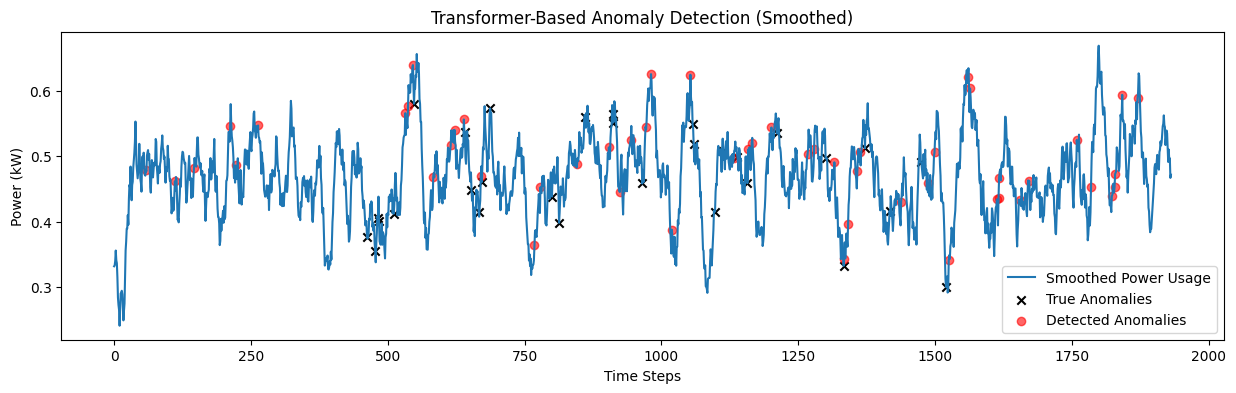

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix

# 1. Load & preprocess dataset (reduced to 2000 rows)
df = pd.read_csv("smart_grid_tx_normalized_encoder_hash1.csv", nrows=2000)
df = df.sort_values("block_index")[["block_index", "Power_Consumption(kW)"]]
df.rename(columns={"Power_Consumption(kW)": "power"}, inplace=True)
df["power"] = df["power"].ffill()

# 2. Inject synthetic anomalies (same as before)
np.random.seed(42)
anomaly_indices = np.random.choice(df.index[500:1900], size=30, replace=False)
df["anomaly"] = 0
df.loc[anomaly_indices, "power"] *= np.random.uniform(0.1, 0.5, size=30)
df.loc[anomaly_indices, "anomaly"] = 1

# 3. Create sliding windows
def create_windows(data, window_size=48):
    X, y, labels = [], [], []
    for i in range(len(data) - window_size - 1):
        window = data["power"].values[i:i + window_size]
        target = data["power"].values[i + window_size]
        label = int(data["anomaly"].values[i + window_size])
        X.append(window)
        y.append(target)
        labels.append(label)
    return np.array(X), np.array(y), np.array(labels)

window_size = 48
X, y, true_labels = create_windows(df, window_size)
X_tensor = torch.tensor(X).unsqueeze(-1).float()
y_tensor = torch.tensor(y).float()

# 4. Transformer model
class TransformerAnomalyDetector(nn.Module):
    def __init__(self, seq_len, d_model=32, nhead=2, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.transformer(x)
        return self.output_proj(x)

model = TransformerAnomalyDetector(seq_len=window_size)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# 5. Training (10 epochs)
start_time = time.time()
epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    pred = model(X_tensor)[:, -1].squeeze()
    loss = criterion(pred, y_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
train_time = time.time() - start_time

# 6. Anomaly detection
model.eval()
with torch.no_grad():
    preds = model(X_tensor)[:, -1].squeeze()
    errors = torch.abs(preds - y_tensor)

# 7. Threshold-based binary classification
threshold = errors.mean() + 2 * errors.std()
pred_labels = (errors > threshold).int().numpy()

# 8. Evaluation metrics
auc = roc_auc_score(true_labels, errors.numpy())
tn, fp, fn, tp = confusion_matrix(true_labels, pred_labels).ravel()
fpr = fp / (fp + tn + 1e-6)

print(f"\n📊 AUC Score: {auc:.4f}")
print(f"🚨 False Positive Rate: {fpr:.4f}")
print(f"⏱️ Training Time: {train_time:.2f} seconds")

# 9. Visualization
window = 20
smoothed = np.convolve(y_tensor.numpy(), np.ones(window)/window, mode='valid')
plt.figure(figsize=(15, 4))
plt.plot(smoothed, label="Smoothed Power Usage")
plt.scatter(np.where(true_labels[window-1:] == 1), smoothed[true_labels[window-1:] == 1], color='black', marker='x', label="True Anomalies")
plt.scatter(np.where(pred_labels[window-1:] == 1), smoothed[pred_labels[window-1:] == 1], color='red', alpha=0.6, label="Detected Anomalies")
plt.legend()
plt.title("Transformer-Based Anomaly Detection (Smoothed)")
plt.xlabel("Time Steps")
plt.ylabel("Power (kW)")
plt.show()




Epoch 1/10, Loss: 0.1266
Epoch 2/10, Loss: 0.0769
Epoch 3/10, Loss: 0.0758
Epoch 4/10, Loss: 0.0755
Epoch 5/10, Loss: 0.0753
Epoch 6/10, Loss: 0.0750
Epoch 7/10, Loss: 0.0751
Epoch 8/10, Loss: 0.0752
Epoch 9/10, Loss: 0.0749
Epoch 10/10, Loss: 0.0749

📊 AUC Score: 0.4929
🚨 False Positive Rate: 0.0000
⏱️ Training Time: 2663.05 seconds


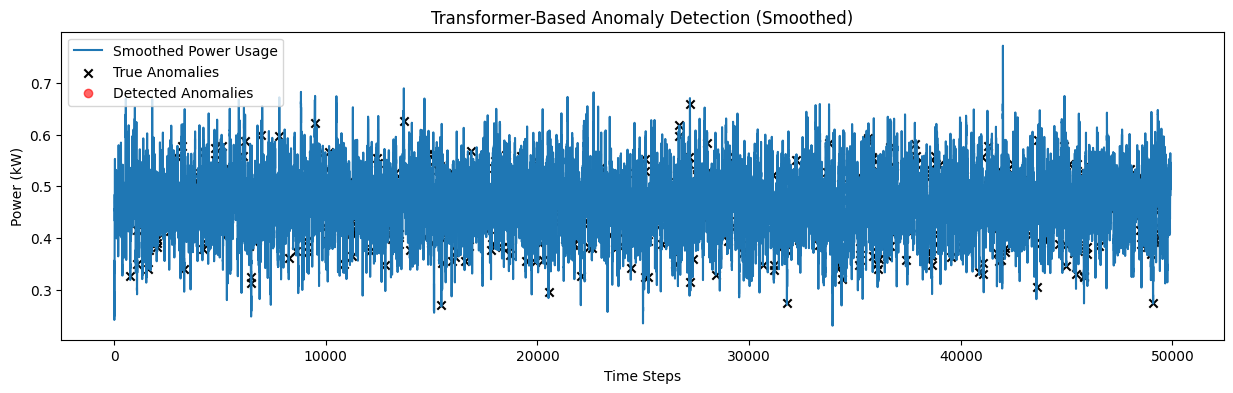

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader

# 1. Load & preprocess dataset (50,000 rows)
df = pd.read_csv("smart_grid_tx_normalized_encoder_hash1.csv", nrows=50000)
df = df.sort_values("block_index")[["block_index", "Power_Consumption(kW)"]]
df.rename(columns={"Power_Consumption(kW)": "power"}, inplace=True)
df["power"] = df["power"].ffill()

# 2. Inject synthetic anomalies
np.random.seed(42)
anomaly_indices = np.random.choice(df.index[500:49500], size=750, replace=False)
df["anomaly"] = 0
df.loc[anomaly_indices, "power"] *= np.random.uniform(0.1, 0.5, size=750)
df.loc[anomaly_indices, "anomaly"] = 1

# 3. Create sliding windows
def create_windows(data, window_size=48):
    X, y, labels = [], [], []
    for i in range(len(data) - window_size - 1):
        window = data["power"].values[i:i + window_size]
        target = data["power"].values[i + window_size]
        label = int(data["anomaly"].values[i + window_size])
        X.append(window)
        y.append(target)
        labels.append(label)
    return np.array(X), np.array(y), np.array(labels)

window_size = 48
X, y, true_labels = create_windows(df, window_size)

# Convert to tensors
X_tensor = torch.tensor(X).unsqueeze(-1).float()
y_tensor = torch.tensor(y).float()
dataset = TensorDataset(X_tensor, y_tensor)
batch_size = 256
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 4. Transformer model
class TransformerAnomalyDetector(nn.Module):
    def __init__(self, seq_len, d_model=32, nhead=2, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.transformer(x)
        return self.output_proj(x)

model = TransformerAnomalyDetector(seq_len=window_size)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# 5. Training with mini-batches
start_time = time.time()
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for xb, yb in loader:
        optimizer.zero_grad()
        pred = model(xb)[:, -1].squeeze()
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    epoch_loss = running_loss / len(dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")
train_time = time.time() - start_time

# 6. Anomaly detection (par batch pour mémoire)
model.eval()
errors = []
with torch.no_grad():
    for xb, yb in loader:
        pred = model(xb)[:, -1].squeeze()
        errors.append(torch.abs(pred - yb))
errors = torch.cat(errors)

# 7. Threshold-based binary classification
threshold = errors.mean() + 2 * errors.std()
pred_labels = (errors > threshold).int().numpy()

# 8. Evaluation metrics
auc = roc_auc_score(true_labels, errors.numpy())
tn, fp, fn, tp = confusion_matrix(true_labels, pred_labels).ravel()
fpr = fp / (fp + tn + 1e-6)

print(f"\n📊 AUC Score: {auc:.4f}")
print(f"🚨 False Positive Rate: {fpr:.4f}")
print(f"⏱️ Training Time: {train_time:.2f} seconds")
window = 20
smoothed = np.convolve(y_tensor.numpy(), np.ones(window)/window, mode='valid')
plt.figure(figsize=(15, 4))
plt.plot(smoothed, label="Smoothed Power Usage")
plt.scatter(np.where(true_labels[window-1:] == 1), smoothed[true_labels[window-1:] == 1], color='black', marker='x', label="True Anomalies")
plt.scatter(np.where(pred_labels[window-1:] == 1), smoothed[pred_labels[window-1:] == 1], color='red', alpha=0.6, label="Detected Anomalies")
plt.legend()
plt.title("Transformer-Based Anomaly Detection (Smoothed)")
plt.xlabel("Time Steps")
plt.ylabel("Power (kW)")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix

# 1. Charger le dataset (2000 lignes pour test, tu peux enlever nrows après)
df = pd.read_csv("smart_grid_tx_normalized_encoder_hash1.csv", nrows=2000)

# On ne garde que les colonnes utiles
df = df[["Timestamp", "Power_Consumption(kW)", "is_anomaly"]]
df = df.sort_values("Timestamp")
df.rename(columns={"Power_Consumption(kW)": "power"}, inplace=True)

# Nettoyage valeurs manquantes
df["power"] = df["power"].ffill()

# Labels réels fournis dans la data
df["anomaly"] = df["is_anomaly"]

# 2. Création des fenêtres temporelles
def create_windows(data, window_size=48):
    X, y, labels = [], [], []
    for i in range(len(data) - window_size - 1):
        window = data["power"].values[i:i + window_size]
        target = data["power"].values[i + window_size]
        label = int(data["anomaly"].values[i + window_size])
        X.append(window)
        y.append(target)
        labels.append(label)
    return np.array(X), np.array(y), np.array(labels)

window_size = 48
X, y, true_labels = create_windows(df, window_size)
X_tensor = torch.tensor(X).unsqueeze(-1).float()
y_tensor = torch.tensor(y).float()

# 3. Modèle Transformer
class TransformerAnomalyDetector(nn.Module):
    def __init__(self, seq_len, d_model=32, nhead=2, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.transformer(x)
        return self.output_proj(x)

model = TransformerAnomalyDetector(seq_len=window_size)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# 4. Entraînement
start_time = time.time()
epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    pred = model(X_tensor)[:, -1].squeeze()
    loss = criterion(pred, y_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
train_time = time.time() - start_time

# 5. Détection d'anomalies
model.eval()
with torch.no_grad():
    preds = model(X_tensor)[:, -1].squeeze()
    errors = torch.abs(preds - y_tensor)

# 6. Classification binaire via seuil
threshold = errors.mean() + 2 * errors.std()
pred_labels = (errors > threshold).int().numpy()

# 7. Évaluation
auc = roc_auc_score(true_labels, errors.numpy())
tn, fp, fn, tp = confusion_matrix(true_labels, pred_labels).ravel()
fpr = fp / (fp + tn + 1e-6)

print(f"\n📊 AUC Score: {auc:.4f}")
print(f"🚨 False Positive Rate: {fpr:.4f}")
print(f"⏱️ Training Time: {train_time:.2f} seconds")

# 8. Visualisation
plt.figure(figsize=(15, 4))
plt.plot(y_tensor.numpy(), label="Power Usage")
plt.scatter(np.where(true_labels == 1), y_tensor.numpy()[true_labels == 1], color='black', marker='x', label="True Anomalies")
plt.scatter(np.where(pred_labels == 1), y_tensor.numpy()[pred_labels == 1], color='red', alpha=0.6, label="Detected Anomalies")
plt.legend()
plt.title("Transformer-Based Anomaly Detection on Smart Grid Data (2000 rows)")
plt.xlabel("Time Steps")
plt.ylabel("Power (kW)")
plt.show()


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# ===============================
# 1. Exemple de DataFrame simulé
# ===============================
# Remplace par ton vrai dataframe
n_samples = 2000
df = pd.DataFrame({
    "feature1": np.random.randn(n_samples),
    "feature2": np.random.randn(n_samples),
    "label": np.random.randint(0, 2, size=n_samples)  # 0 ou 1
})

# ===============================
# 2. Fonction create_windows
# ===============================
def create_windows(df, window_size):
    X, y, labels = [], [], []
    data = df[["feature1", "feature2"]].values
    target = df["label"].values

    for i in range(len(df) - window_size):
        X.append(data[i:i + window_size])
        y.append(target[i + window_size])  # la valeur après la fenêtre
        labels.append(target[i + window_size])

    return np.array(X), np.array(y), np.array(labels)

# ===============================
# 3. Création des fenêtres
# ===============================
window_size = 48
X, y, true_labels = create_windows(df, window_size)

# Split en train (80%) et test (20%)
X_train, X_test, y_train, y_test, labels_train, labels_test = train_test_split(
    X, y, true_labels, test_size=0.2, shuffle=False
)

# ===============================
# 4. Conversion en tenseurs PyTorch
# ===============================
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# ===============================
# 5. Définition du modèle LSTM
# ===============================
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Dernier pas de temps
        out = self.fc(out)
        return self.sigmoid(out)

# Hyperparamètres
input_size = X.shape[2]
hidden_size = 32
num_layers = 2
epochs = 5
batch_size = 64
learning_rate = 0.001

model = LSTMModel(input_size, hidden_size, num_layers)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# ===============================
# 6. Entraînement
# ===============================
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# ===============================
# 7. Évaluation
# ===============================
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor).squeeze()
    y_pred_labels = (y_pred_test > 0.5).int()

accuracy = (y_pred_labels == y_test_tensor.int()).sum().item() / len(y_test_tensor)
print(f"Accuracy: {accuracy:.4f}")


Epoch 1/5, Loss: 0.7071
Epoch 2/5, Loss: 0.6921
Epoch 3/5, Loss: 0.6984
Epoch 4/5, Loss: 0.6938
Epoch 5/5, Loss: 0.6994
Accuracy: 0.4476


Epoch 1/10, Loss: 0.2809
Epoch 2/10, Loss: 0.2671
Epoch 3/10, Loss: 0.2537
Epoch 4/10, Loss: 0.2407
Epoch 5/10, Loss: 0.2281
Epoch 6/10, Loss: 0.2159
Epoch 7/10, Loss: 0.2039
Epoch 8/10, Loss: 0.1921
Epoch 9/10, Loss: 0.1806
Epoch 10/10, Loss: 0.1693

📊 AUC Score: 0.4959
🚨 False Positive Rate: 0.0029


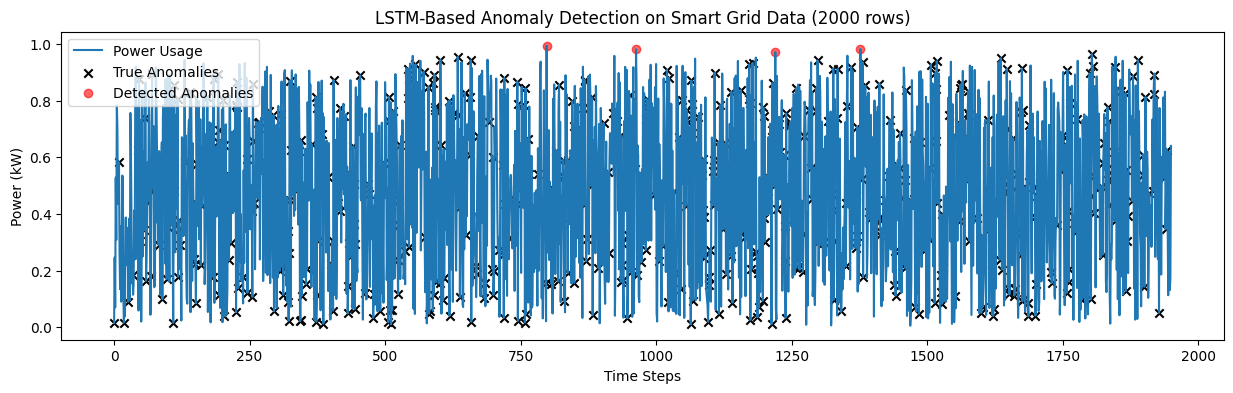

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix

# ===============================
# 1. Charger le dataset
# ===============================
df = pd.read_csv("smart_grid_tx_normalized_encoder_hash.csv", nrows=2000)
df = df[["Timestamp", "Power_Consumption(kW)", "is_anomaly"]]
df = df.sort_values("Timestamp")
df.rename(columns={"Power_Consumption(kW)": "power"}, inplace=True)
df["power"] = df["power"].ffill()
df["anomaly"] = df["is_anomaly"]

# ===============================
# 2. Création des fenêtres
# ===============================
def create_windows(data, window_size=48):
    X, y, labels = [], [], []
    for i in range(len(data) - window_size - 1):
        window = data["power"].values[i:i + window_size]
        target = data["power"].values[i + window_size]
        label = int(data["anomaly"].values[i + window_size])
        X.append(window)
        y.append(target)
        labels.append(label)
    return np.array(X), np.array(y), np.array(labels)

window_size = 48
X, y, true_labels = create_windows(df, window_size)
X_tensor = torch.tensor(X).unsqueeze(-1).float()
y_tensor = torch.tensor(y).float()

# ===============================
# 3. Modèle LSTM
# ===============================
class LSTMAnomalyDetector(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # dernier pas de temps
        return self.fc(out)

model = LSTMAnomalyDetector()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# ===============================
# 4. Entraînement
# ===============================
epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    pred = model(X_tensor).squeeze()
    loss = criterion(pred, y_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# ===============================
# 5. Détection d'anomalies
# ===============================
model.eval()
with torch.no_grad():
    preds = model(X_tensor).squeeze()
    errors = torch.abs(preds - y_tensor)

threshold = errors.mean() + 2 * errors.std()
pred_labels = (errors > threshold).int().numpy()

# ===============================
# 6. Évaluation
# ===============================
auc = roc_auc_score(true_labels, errors.numpy())
tn, fp, fn, tp = confusion_matrix(true_labels, pred_labels).ravel()
fpr = fp / (fp + tn + 1e-6)

print(f"\n📊 AUC Score: {auc:.4f}")
print(f"🚨 False Positive Rate: {fpr:.4f}")

# ===============================
# 7. Visualisation
# ===============================
plt.figure(figsize=(15, 4))
plt.plot(y_tensor.numpy(), label="Power Usage")
plt.scatter(np.where(true_labels == 1), y_tensor.numpy()[true_labels == 1],
            color='black', marker='x', label="True Anomalies")
plt.scatter(np.where(pred_labels == 1), y_tensor.numpy()[pred_labels == 1],
            color='red', alpha=0.6, label="Detected Anomalies")
plt.legend()
plt.title("LSTM-Based Anomaly Detection on Smart Grid Data (2000 rows)")
plt.xlabel("Time Steps")
plt.ylabel("Power (kW)")
plt.show()


Epoch 1/5, Loss: 0.6042
Epoch 2/5, Loss: 0.4891
Epoch 3/5, Loss: 0.7437
Epoch 4/5, Loss: 0.6036
Epoch 5/5, Loss: 0.5259

✅ Accuracy: 0.7397
📊 AUC Score: 0.4948
🚨 False Positive Rate: 0.0000


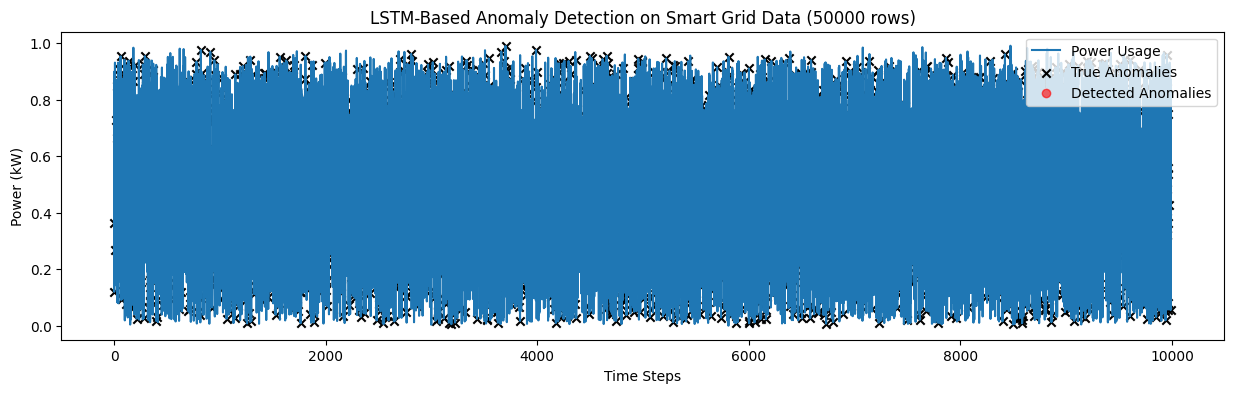

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix

# ===============================
# 1. Charger le dataset
# ===============================
df = pd.read_csv("smart_grid_tx_normalized_encoder_hash.csv", nrows=50000)

# Colonnes utiles
df = df[["Timestamp", "Power_Consumption(kW)", "is_anomaly"]]
df = df.sort_values("Timestamp")
df.rename(columns={"Power_Consumption(kW)": "power"}, inplace=True)
df["power"] = df["power"].ffill()  # remplir valeurs manquantes
df["anomaly"] = df["is_anomaly"]

# ===============================
# 2. Fonction create_windows
# ===============================
def create_windows(data, window_size=48):
    X, y, labels = [], [], []
    for i in range(len(data) - window_size - 1):
        window = data["power"].values[i:i + window_size]
        target = data["anomaly"].values[i + window_size]  # classification
        X.append(window)
        y.append(target)
        labels.append(target)
    return np.array(X), np.array(y), np.array(labels)

window_size = 48
X, y, true_labels = create_windows(df, window_size)

# Train/test split
X_train, X_test, y_train, y_test, labels_train, labels_test = train_test_split(
    X, y, true_labels, test_size=0.2, shuffle=False
)

# ===============================
# 3. Conversion en tenseurs
# ===============================
X_train_tensor = torch.tensor(X_train).unsqueeze(-1).float()
y_train_tensor = torch.tensor(y_train).float()
X_test_tensor = torch.tensor(X_test).unsqueeze(-1).float()
y_test_tensor = torch.tensor(y_test).float()

# ===============================
# 4. Modèle LSTM
# ===============================
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # dernier pas de temps
        out = self.fc(out)
        return self.sigmoid(out)

model = LSTMModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ===============================
# 5. Entraînement
# ===============================
epochs = 5
batch_size = 64
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# ===============================
# 6. Évaluation
# ===============================
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor).squeeze()
    y_pred_labels = (y_pred_test > 0.5).int()

accuracy = (y_pred_labels == y_test_tensor.int()).sum().item() / len(y_test_tensor)
auc = roc_auc_score(y_test_tensor, y_pred_test)
tn, fp, fn, tp = confusion_matrix(y_test_tensor.int(), y_pred_labels).ravel()
fpr = fp / (fp + tn + 1e-6)

print(f"\n✅ Accuracy: {accuracy:.4f}")
print(f"📊 AUC Score: {auc:.4f}")
print(f"🚨 False Positive Rate: {fpr:.4f}")

# ===============================
# 7. Visualisation style anomalies
# ===============================
plt.figure(figsize=(15, 4))
plt.plot(range(len(y_test_tensor)), df["power"].values[-len(y_test_tensor):], label="Power Usage")
plt.scatter(np.where(y_test_tensor.numpy() == 1),
            df["power"].values[-len(y_test_tensor):][y_test_tensor.numpy() == 1],
            color='black', marker='x', label="True Anomalies")
plt.scatter(np.where(y_pred_labels.numpy() == 1),
            df["power"].values[-len(y_test_tensor):][y_pred_labels.numpy() == 1],
            color='red', alpha=0.6, label="Detected Anomalies")
plt.legend()
plt.title("LSTM-Based Anomaly Detection on Smart Grid Data (50000 rows)")
plt.xlabel("Time Steps")
plt.ylabel("Power (kW)")
plt.show()


Epoch 1/5, Loss: 0.6919
Epoch 2/5, Loss: 0.6919
Epoch 3/5, Loss: 0.6919
Epoch 4/5, Loss: 0.6919
Epoch 5/5, Loss: 0.6919

📊 AUC Score: 0.4924
🚨 False Positive Rate: 0.0004


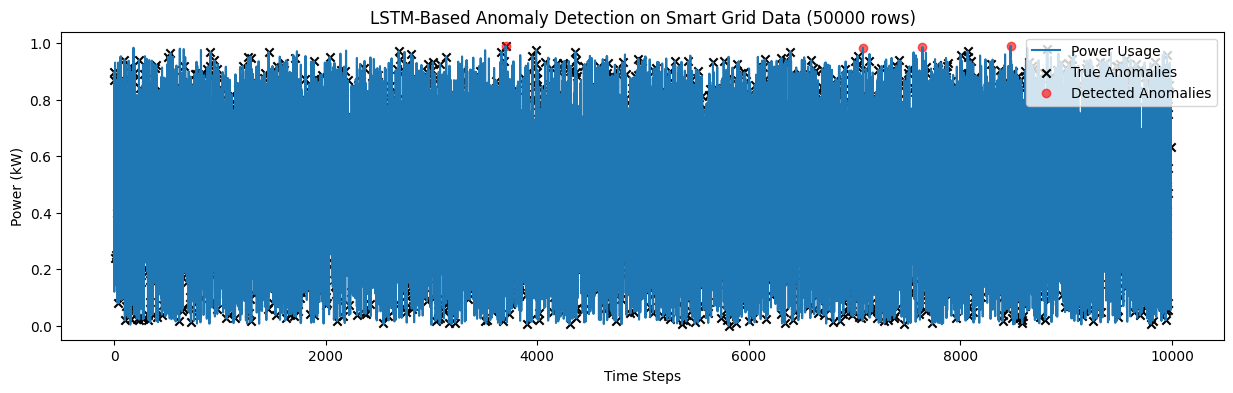

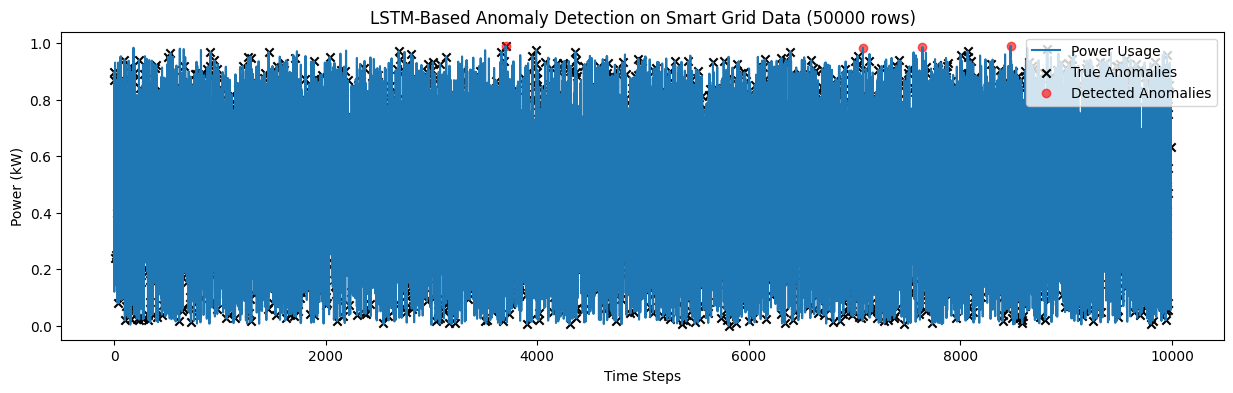

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix

# ===============================
# 1. Charger le dataset
# ===============================
df = pd.read_csv("smart_grid_tx_normalized_encoder_hash1.csv", nrows=50000)
df = df[["Timestamp", "Power_Consumption(kW)", "is_anomaly"]]
df = df.sort_values("Timestamp")
df.rename(columns={"Power_Consumption(kW)": "power"}, inplace=True)
df["power"] = df["power"].ffill()
df["anomaly"] = df["is_anomaly"]

# ===============================
# 2. Création des fenêtres
# ===============================
def create_windows(data, window_size=48):
    X, y, labels = [], [], []
    for i in range(len(data) - window_size - 1):
        window = data["power"].values[i:i + window_size]
        target = data["power"].values[i + window_size]
        label = int(data["anomaly"].values[i + window_size])
        X.append(window)
        y.append(target)
        labels.append(label)
    X = np.array(X)[..., np.newaxis]  # ajouter dimension feature
    return X, np.array(y), np.array(labels)

window_size = 48
X, y, true_labels = create_windows(df, window_size)

# ===============================
# 3. Split train/test
# ===============================
X_train, X_test, y_train, y_test, labels_train, labels_test = train_test_split(
    X, y, true_labels, test_size=0.2, shuffle=False
)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# ===============================
# 4. Définition du modèle LSTM
# ===============================
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # dernier pas de temps
        out = self.fc(out)
        return self.sigmoid(out)

input_size = X_train_tensor.shape[2]  # 1 feature
model = LSTMModel(input_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ===============================
# 5. Entraînement
# ===============================
batch_size = 64
epochs = 5
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

# ===============================
# 6. Détection d’anomalies
# ===============================
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor).squeeze()
    errors = torch.abs(y_pred_test - y_test_tensor)
    
# Seuil = moyenne + 2*écart-type
threshold = errors.mean() + 2 * errors.std()
pred_labels = (errors > threshold).int()

# ===============================
# 7. Évaluation
# ===============================
auc = roc_auc_score(labels_test, errors.numpy())
tn, fp, fn, tp = confusion_matrix(labels_test, pred_labels.numpy()).ravel()
fpr = fp / (fp + tn + 1e-6)

print(f"\n📊 AUC Score: {auc:.4f}")
print(f"🚨 False Positive Rate: {fpr:.4f}")

# ===============================
# 8. Visualisation
# ===============================
plt.figure(figsize=(15,4))
plt.plot(y_test_tensor.numpy(), label="Power Usage")
plt.scatter(np.where(labels_test==1), y_test_tensor.numpy()[labels_test==1],
            color='black', marker='x', label="True Anomalies")
plt.scatter(np.where(pred_labels.numpy()==1), y_test_tensor.numpy()[pred_labels.numpy()==1],
            color='red', alpha=0.6, label="Detected Anomalies")
plt.title("LSTM-Based Anomaly Detection on Smart Grid Data (50000 rows)")
plt.xlabel("Time Steps")
plt.ylabel("Power (kW)")
plt.legend()
plt.show()

# Zoom sur une section avec anomalies
anomaly_indices = np.where(labels_test==1)[0]
if len(anomaly_indices) > 0:
    start, end = max(0, anomaly_indices[0]-50), min(len(y_test_tensor), anomaly_indices[-1]+50)
    plt.figure(figsize=(15,4))
    plt.plot(y_test_tensor.numpy()[start:end], label="Power Usage")
    plt.scatter(np.where(labels_test[start:end]==1)[0], y_test_tensor.numpy()[start:end][labels_test[start:end]==1],
                color='black', marker='x', label="True Anomalies")
    plt.scatter(np.where(pred_labels.numpy()[start:end]==1)[0], y_test_tensor.numpy()[start:end][pred_labels.numpy()[start:end]==1],
                color='red', alpha=0.6, label="Detected Anomalies")
    plt.title("LSTM-Based Anomaly Detection on Smart Grid Data (50000 rows)")
    plt.xlabel("Time Steps")
    plt.ylabel("Power (kW)")
    plt.legend()
    plt.show()
